In [31]:
___Author___='LumberJack Jyss'

In [32]:
print('Global Optimized LumberJack Equities Method\n°OoO_FOREX_Oo0°\nLumberJack Jyss 5779(c)')

Global Optimized LumberJack Equities Method
°OoO_FOREX_Oo0°
LumberJack Jyss 5779(c)


In [33]:
print('Importation des librairies...')
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import pandas_datareader as web
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
print('Librairies importées')

Importation des librairies...
Librairies importées


In [34]:
# Setting the data
start = pd.to_datetime('2015-01-28')
end = pd.to_datetime('2019-03-28')
delta = round((end-start).days)
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("Période d'étude : ",delta)
print('Sur un découpage 80% - 20% de la période : ')
print('Bloc 1 : ',bloc1,' jours \nBloc 2 :',bloc2,' jours')
print('Note : On change de règles de calculs, car tous les jours ne sont pas ouvrés')

Période d'étude :  1520
Sur un découpage 80% - 20% de la période : 
Bloc 1 :  1216  jours 
Bloc 2 : 304  jours
Note : On change de règles de calculs, car tous les jours ne sont pas ouvrés


In [41]:
# fix random seed for reproducibility
np.random.seed(7)
# load the dataset
df = web.DataReader('GOOG','yahoo',start,end)
#dataframe = dataframe.iloc[:,1:]
df.reset_index(inplace=True)
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-01-28,520.127686,507.208801,519.918884,507.208801,1683800.0,507.208801
1,2015-01-29,508.292847,498.456970,508.203339,507.865204,4186400.0,507.865204
2,2015-01-30,536.915344,512.698608,513.036743,531.594604,5606400.0,531.594604
3,2015-02-02,530.082947,515.712036,528.819885,525.587646,2849800.0,525.587646
4,2015-02-03,530.480713,520.396240,525.110291,526.343506,2034800.0,526.343506


In [42]:
#df['DayOfYear'] = df.index.dayofyear
#df['HourOfDay'] = df.index.hour
#df['MonthOfYear'] = df.index.month
df = df.iloc[:,1:]
df = df.drop(columns='Close',axis=1)

In [43]:
df.head()

,High,Low,Open,Volume,Adj Close
0,520.127686,507.208801,519.918884,1683800.0,507.208801
1,508.292847,498.456970,508.203339,4186400.0,507.865204
2,536.915344,512.698608,513.036743,5606400.0,531.594604
3,530.082947,515.712036,528.819885,2849800.0,525.587646
4,530.480713,520.396240,525.110291,2034800.0,526.343506


In [44]:
df = df.fillna(method='ffill')

In [39]:
df[['Open','High','Low','Adj Close']] = np.exp(10*df[['Open','High','Low','Adj Close']]) #See if we can help the model out

/Users/YTsBaCh/Applications/anaconda3/envs/LumberJack/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


In [45]:
df.describe()

,High,Low,Open,Volume,Adj Close
count,1049.000000,1049.000000,1049.000000,1.049000e+03,1049.000000
mean,873.300222,858.029534,865.777153,1.755486e+06,865.937344
std,207.077123,202.690041,204.834931,8.678156e+05,204.948153
min,508.292847,498.456970,508.203339,5.272000e+05,507.208801
25%,722.469971,710.010010,717.059998,1.252000e+06,716.549988
50%,828.484985,821.020020,824.710022,1.532600e+06,824.320007
75%,1062.375000,1039.839966,1050.170044,1.984900e+06,1050.709961
max,1273.890015,1249.020020,1271.000000,1.116490e+07,1268.329956


In [46]:
df.values.shape

(1049, 5)

In [47]:
target_names = ['Adj Close']

In [48]:
shift_mn = 1
shift_steps = shift_mn * 1  # Number of mn.

In [49]:
df_targets = df[target_names].shift(-shift_steps)

In [50]:
x_data = df.values[0:-shift_steps]
x_data = x_data.astype('float32')

In [51]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (1048, 5)


In [52]:
y_data = df_targets.values[:-shift_steps]
y_data = y_data.astype('float32')

In [53]:
#nb of data rows in the dataset
num_data = len(x_data)
num_data

1048

In [54]:
train_split = 0.8

In [55]:
num_train = int(train_split * num_data)
num_train

838

In [56]:
#These are the input-signals for the training- and test-sets
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

1048

In [57]:
#These are the output-signals for the training- and test-sets
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

1048

In [58]:
#number of input-signals
num_x_signals = x_data.shape[1]
num_x_signals

5

In [59]:
#number of output-signals
num_y_signals = y_data.shape[1]
num_y_signals

1

In [60]:
# Scaling data (0-1)
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 498.45697
Max: 11164900.0


In [61]:
x_scaler = MinMaxScaler()

In [62]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [63]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000001


In [64]:
x_test_scaled = x_scaler.transform(x_test)

In [65]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [66]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(838, 5)
(838, 1)


In [67]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [84]:
batch_size = 6

In [91]:
# We adjust the length to be  interesting for the model to work on it but not to heavy to crush our computer
sequence_length = 6 * 4 * 7
sequence_length

168

In [92]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [93]:
x_batch, y_batch = next(generator)

In [94]:
print(x_batch.shape)
print(y_batch.shape)

(6, 168, 5)
(6, 168, 1)


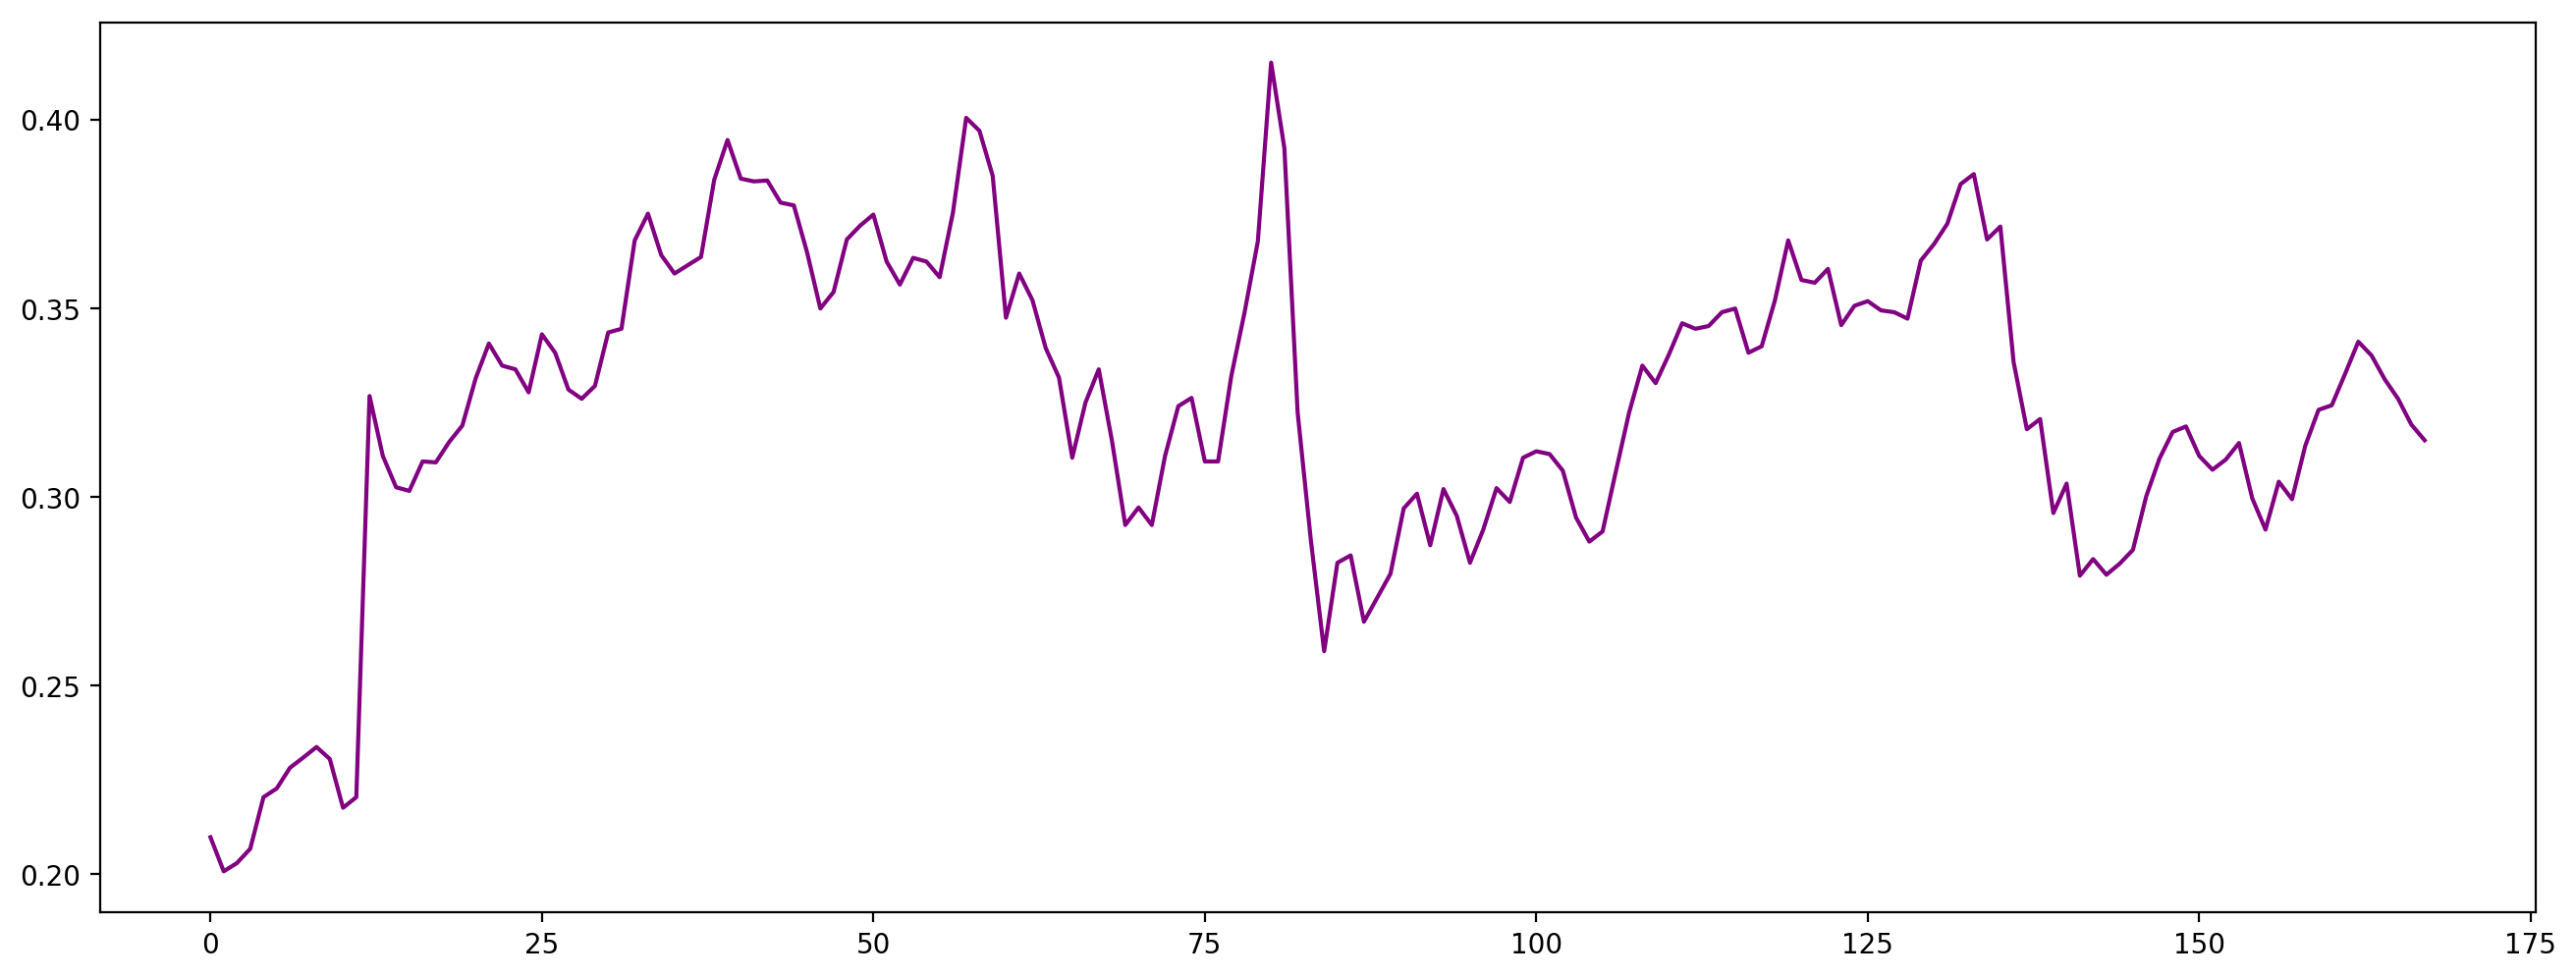

In [95]:
#Lets plot it 

batch = 0   # First sequence in the batch.
signal = 0  # First signal from the input-signals.
seq = x_batch[batch, :, signal]
plt.figure(figsize=(16,6),dpi=200)
plt.plot(seq,color='purple')

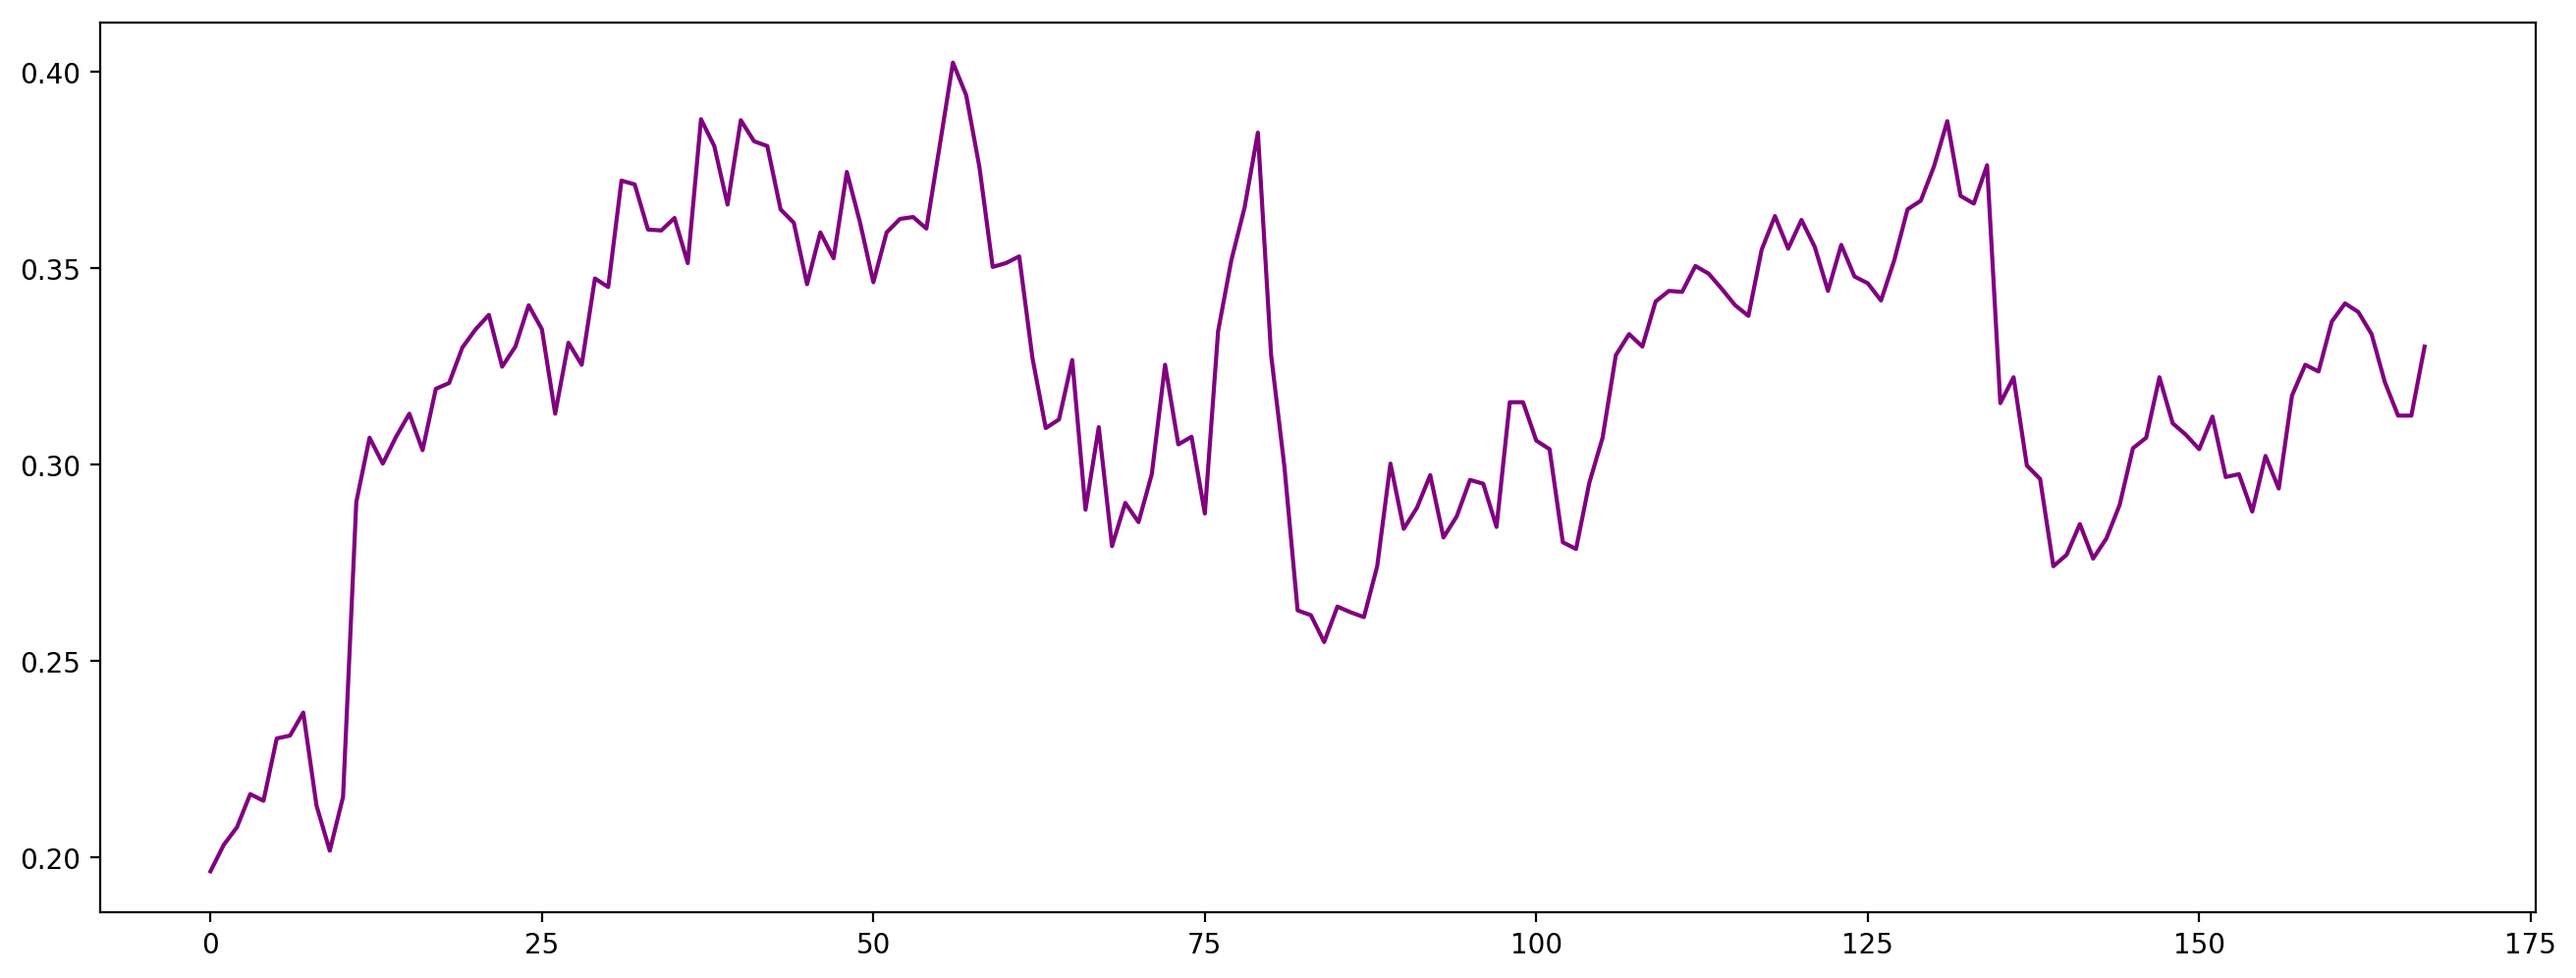

In [96]:
#plot of the batch we want to predict
seq = y_batch[batch, :, signal]
plt.figure(figsize=(16,6),dpi=200)
plt.plot(seq,color='purple')

In [97]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [98]:
model = Sequential()

In [100]:
# The GRU outputs a batch of sequences of 512 values. We want to predict 1 output-signals, 
# so we add a fully-connected (or dense) layer which maps 512 values down to only 1 values.
model.add(Dense(num_y_signals, activation='sigmoid'))

In [101]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [102]:
warmup_steps = 5

In [103]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [104]:
optimizer = RMSprop(lr=1e-4)

In [105]:
len(x_train_scaled),len(y_train_scaled)

(838, 838)

In [106]:
epochs_custom = 10

In [107]:
model.build(x_train_scaled.shape)

In [108]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  6         
_________________________________________________________________
dense_1 (Dense)              multiple                  2         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [109]:
#This is the callback for writing checkpoints during training.
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [110]:
#stopping the model when performance worsens on the valid set
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=10, verbose=1)

In [111]:
#This is the callback for writing the TensorBoard log during training.
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [112]:
#This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since 
# the last epoch (as indicated by patience=0). The learning-rate will be reduced by multiplying it with 
# the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.1 gives a learning-rate of 1e-4. 
# We don't want the learning-rate to go any lower than this.

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-6,
                                       patience=0,
                                       verbose=1)

In [113]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [114]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [119]:
epochs = 100
steps_per_epoch = 400

In [120]:
%%time
model.fit_generator(generator=generator,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch, #should be 100 ##################
                    validation_data=validation_data,
                    callbacks=callbacks,shuffle=False)

Epoch 1/100
383/400 [===========================>..] - ETA: 0s - loss: 0.0203
Epoch 00001: val_loss improved from 0.15691 to 0.15689, saving model to 23_checkpoint.keras
400/400 [==============================] - 0s 1ms/step - loss: 0.0205 - val_loss: 0.1569
Epoch 2/100
373/400 [==========================>...] - ETA: 0s - loss: 0.0202
Epoch 00002: val_loss improved from 0.15689 to 0.15686, saving model to 23_checkpoint.keras
400/400 [==============================] - 1s 1ms/step - loss: 0.0201 - val_loss: 0.1569
Epoch 3/100
369/400 [==========================>...] - ETA: 0s - loss: 0.0203
Epoch 00003: val_loss improved from 0.15686 to 0.15683, saving model to 23_checkpoint.keras
400/400 [==============================] - 1s 1ms/step - loss: 0.0202 - val_loss: 0.1568
Epoch 4/100
373/400 [==========================>...] - ETA: 0s - loss: 0.0200
Epoch 00004: val_loss improved from 0.15683 to 0.15681, saving model to 23_checkpoint.keras
400/400 [==============================] - 1s 1ms/ste

In [121]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [122]:
loss_test_set = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 900us/sample - loss: 0.1545


In [123]:
print("loss (test-set):", loss_test_set)

loss (test-set): 0.15450416505336761


In [124]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [125]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(16,6),dpi=250)
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

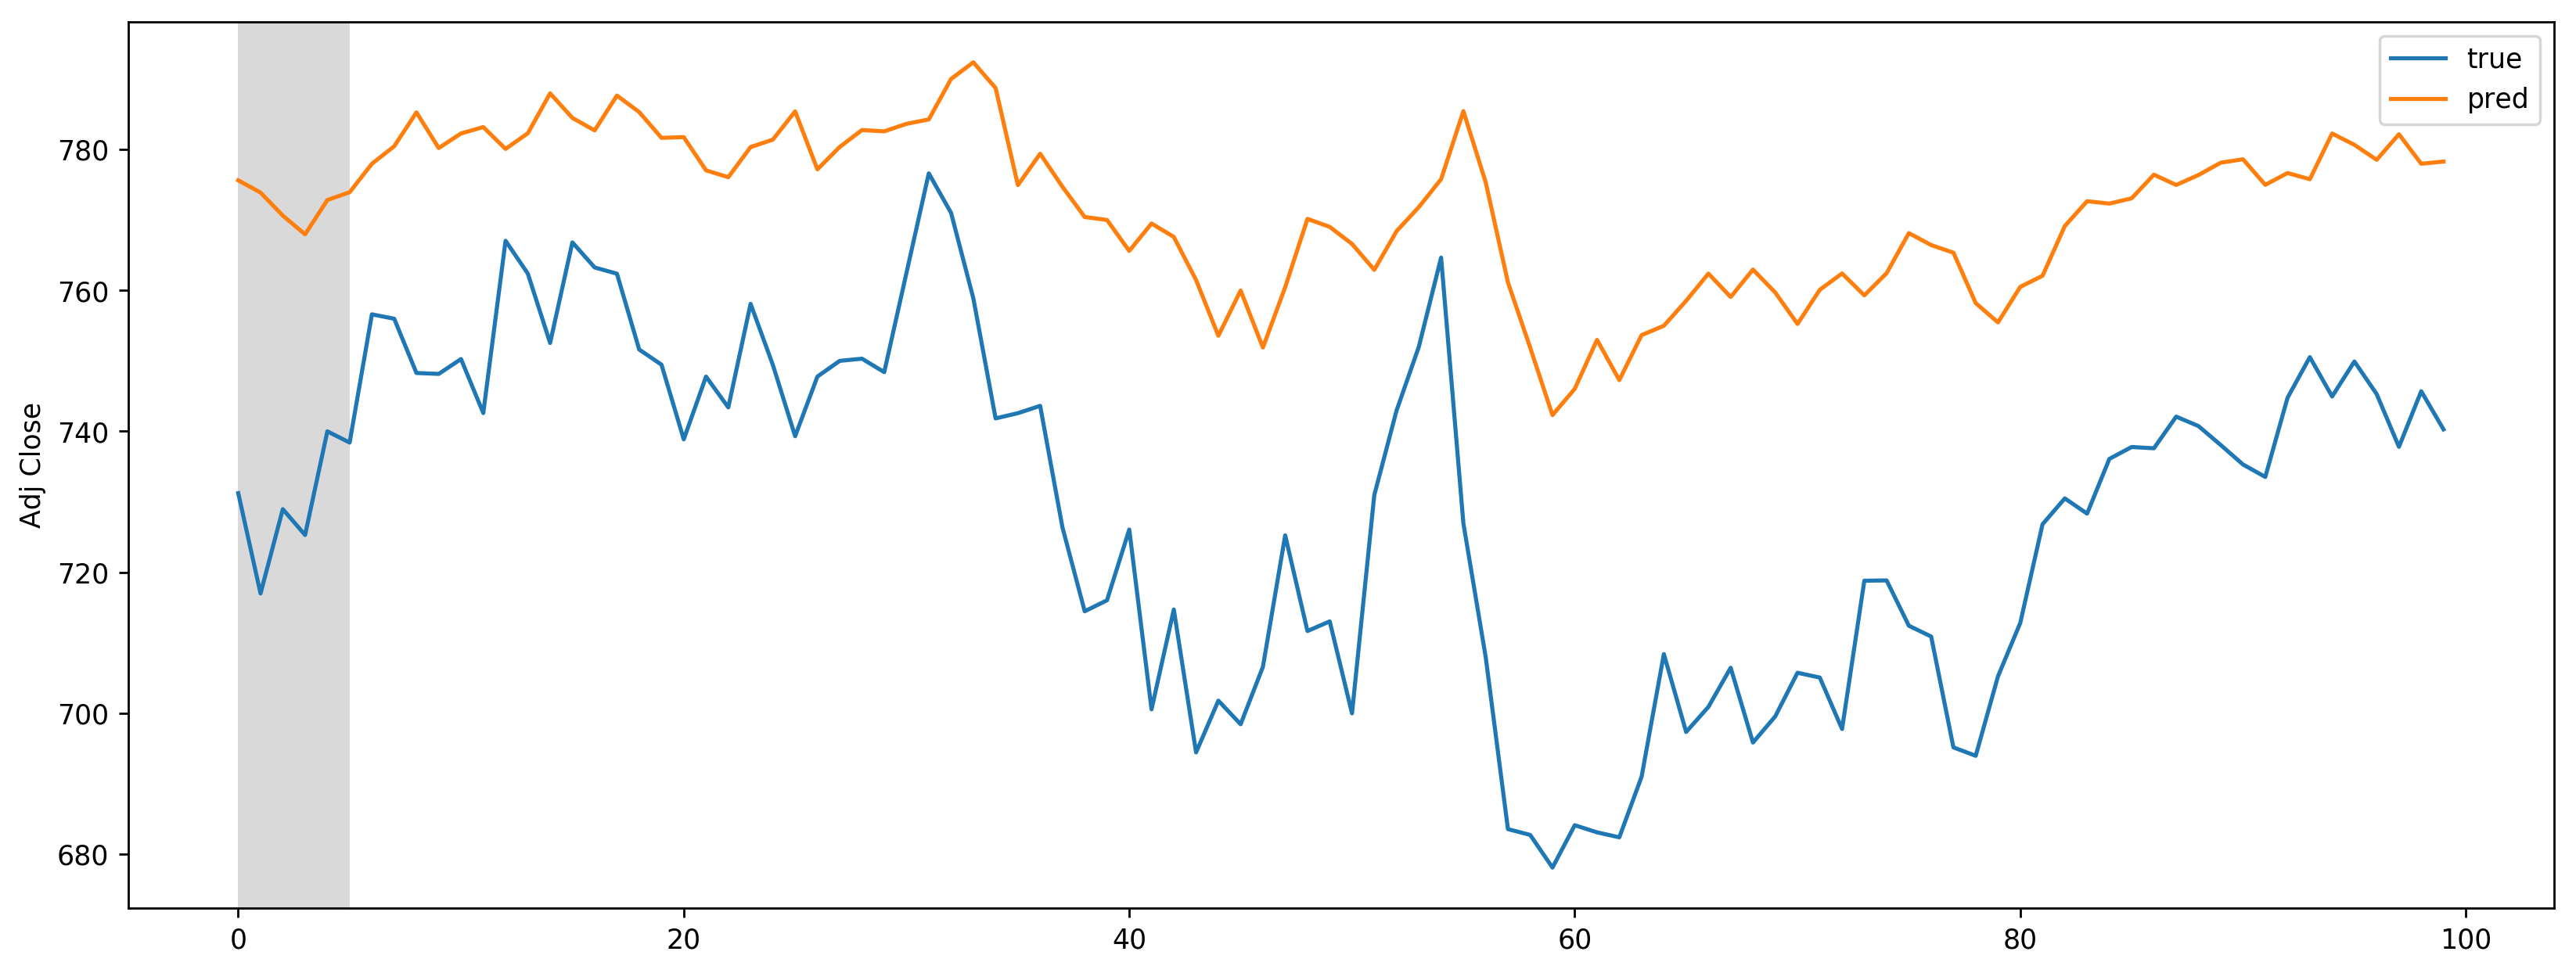

In [128]:
plot_comparison(start_idx=200, length=100, train=True)

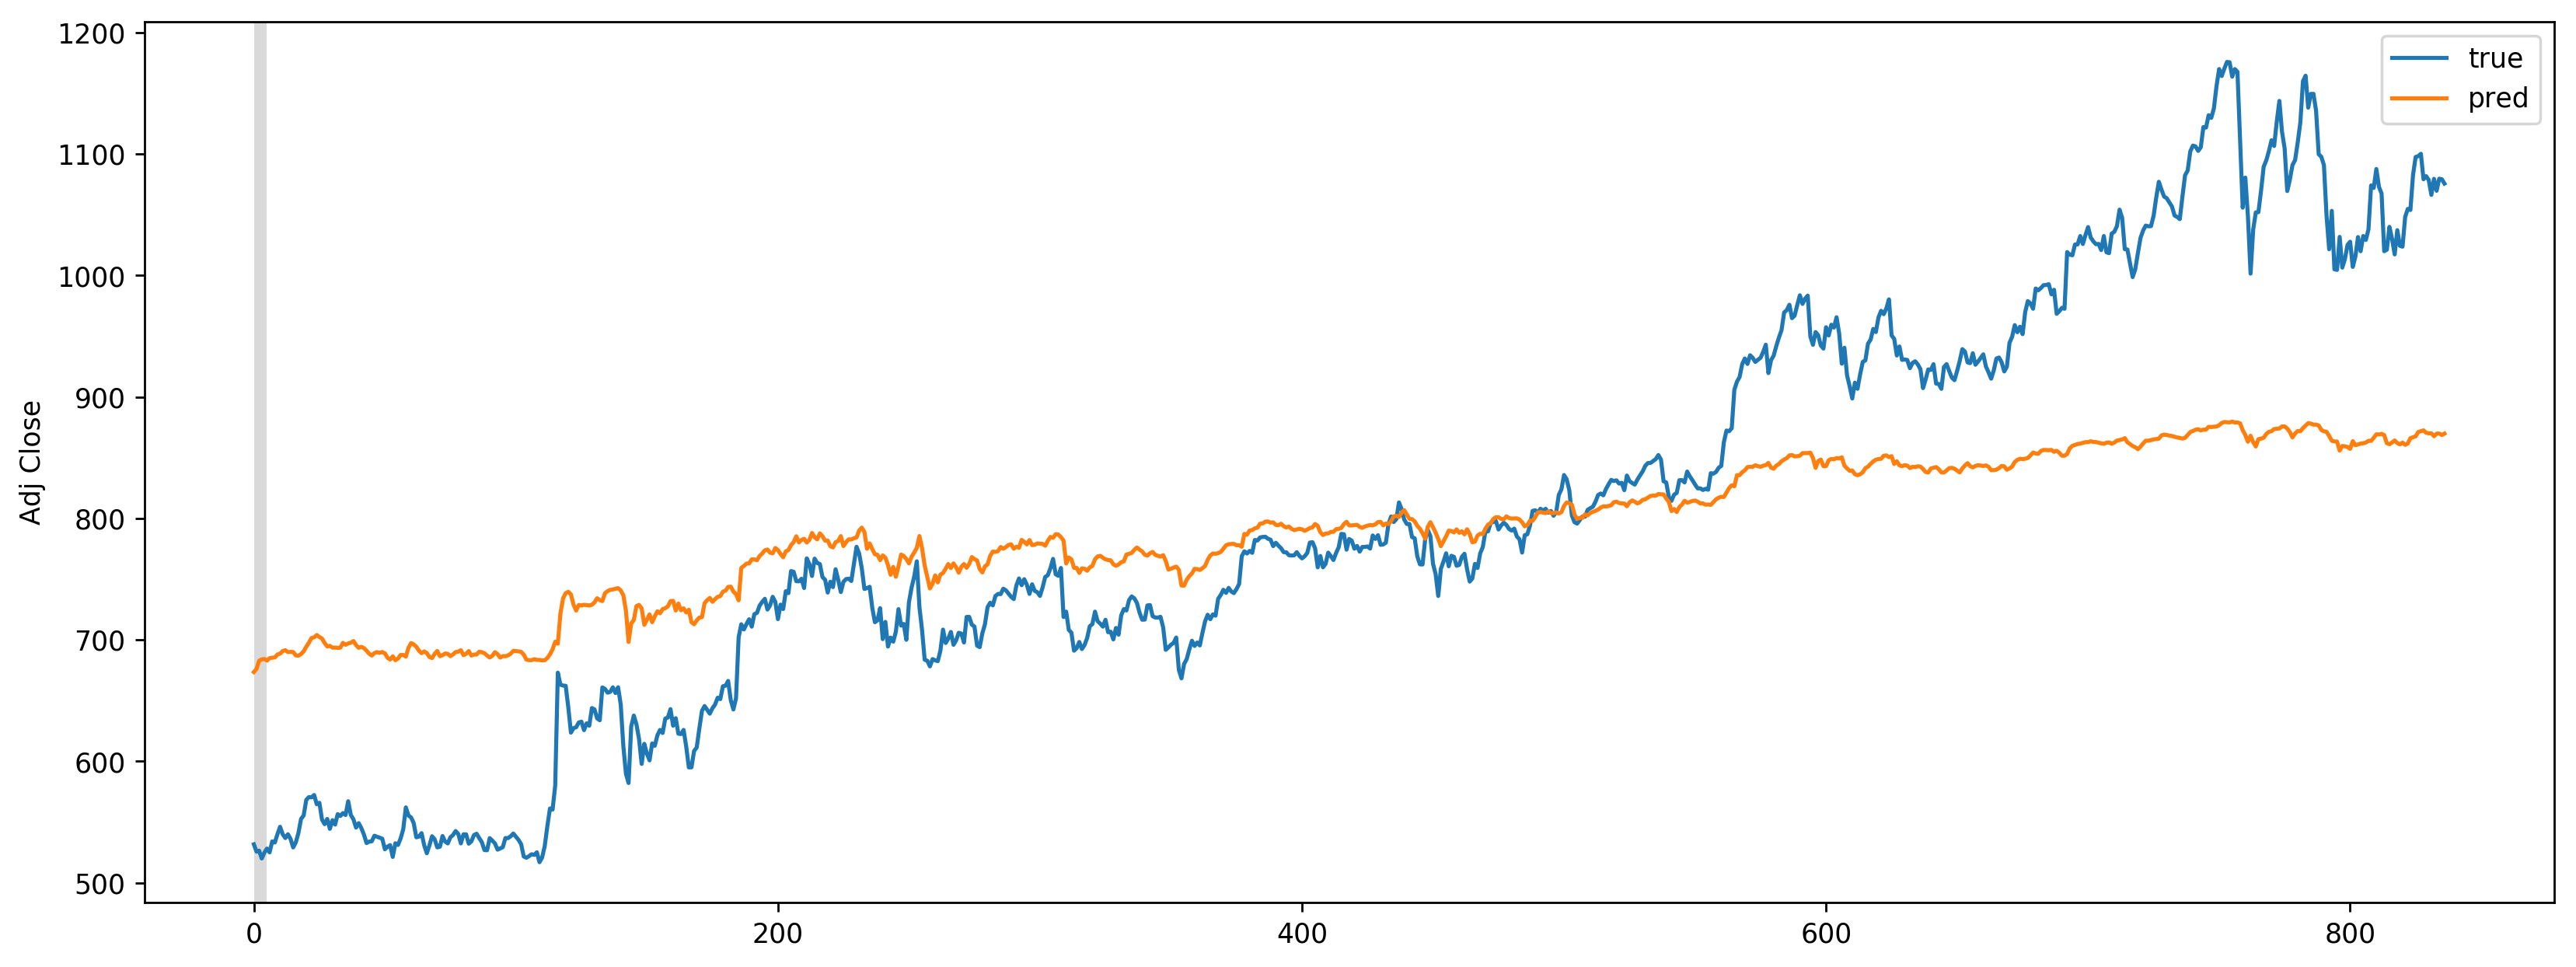

In [129]:
plot_comparison(start_idx=1, length=900, train=True)

In [145]:
def return_pred(start_idx, length=900, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    y_pred_rescaled[:,0] = np.log(y_pred_rescaled[:,0])/10
    y_tc = y_true[:,0]
    y_tc = np.log(y_true[:,0])/10
    
    result = pd.DataFrame({'Close_pred':y_pred_rescaled[:,0],'Close_true':y_tc})
    result['rmse'] = np.sqrt((result['Close_pred'] - result['Close_true'])*
                              (result['Close_pred'] - result['Close_true']))
    result['Delta'] = result['Close_true'] - result['Close_pred']
    
    result = result.tail(len(result)-200) #giving at least 50 learning steps to the model
    return(result)

In [146]:
result = return_pred(start_idx = 0, length=900, train=False)
result

,Close_pred,Close_true,rmse,Delta
200,0.678092,0.707704,0.029613,0.029613
201,0.678035,0.707687,0.029653,0.029653
202,0.678015,0.708912,0.030896,0.030896
203,0.678075,0.710985,0.032911,0.032911
204,0.678161,0.711602,0.033441,0.033441
205,0.678304,0.709465,0.031160,0.031160
206,0.678283,0.708423,0.030140,0.030140
207,0.678113,0.707718,0.029605,0.029605
208,0.678071,0.706734,0.028663,0.028663
209,0.677966,0.706347,0.028381,0.028381


In [147]:
result.describe()

,Close_pred,Close_true,rmse,Delta
count,10.000000,10.000000,10.000000,10.000000
mean,0.678111,0.708558,0.030446,0.030446
std,0.000110,0.001717,0.001678,0.001678
min,0.677966,0.706347,0.028381,0.028381
25%,0.678044,0.707692,0.029607,0.029607
50%,0.678083,0.708070,0.029896,0.029896
75%,0.678149,0.709327,0.031094,0.031094
max,0.678304,0.711602,0.033441,0.033441


In [148]:
rmse = result.describe()['rmse'][1]
data_history.append([rmse,loss_test_set,shift_mn,epochs,steps_per_epoch,batch_size,sequence_length])
df = pd.DataFrame(data_history,columns=['rmse','trainScore','shift_mn',
                                        'epochs','steps_per_epoch','batch_size','sequence_length'])
df.head()

,rmse,trainScore,shift_mn,epochs,steps_per_epoch,batch_size,sequence_length
0,0.030446,0.154504,1,100,400,6,168
1,0.030446,0.154504,1,100,400,6,168


In [149]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  6         
_________________________________________________________________
dense_1 (Dense)              multiple                  2         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [150]:
error = pd.DataFrame()
error = ((result.iloc[:,1] - result.iloc[:,0])/result.iloc[:,1])*100
error.head()

200    4.184319
201    4.190095
202    4.358272
203    4.628911
204    4.699430
dtype: float32

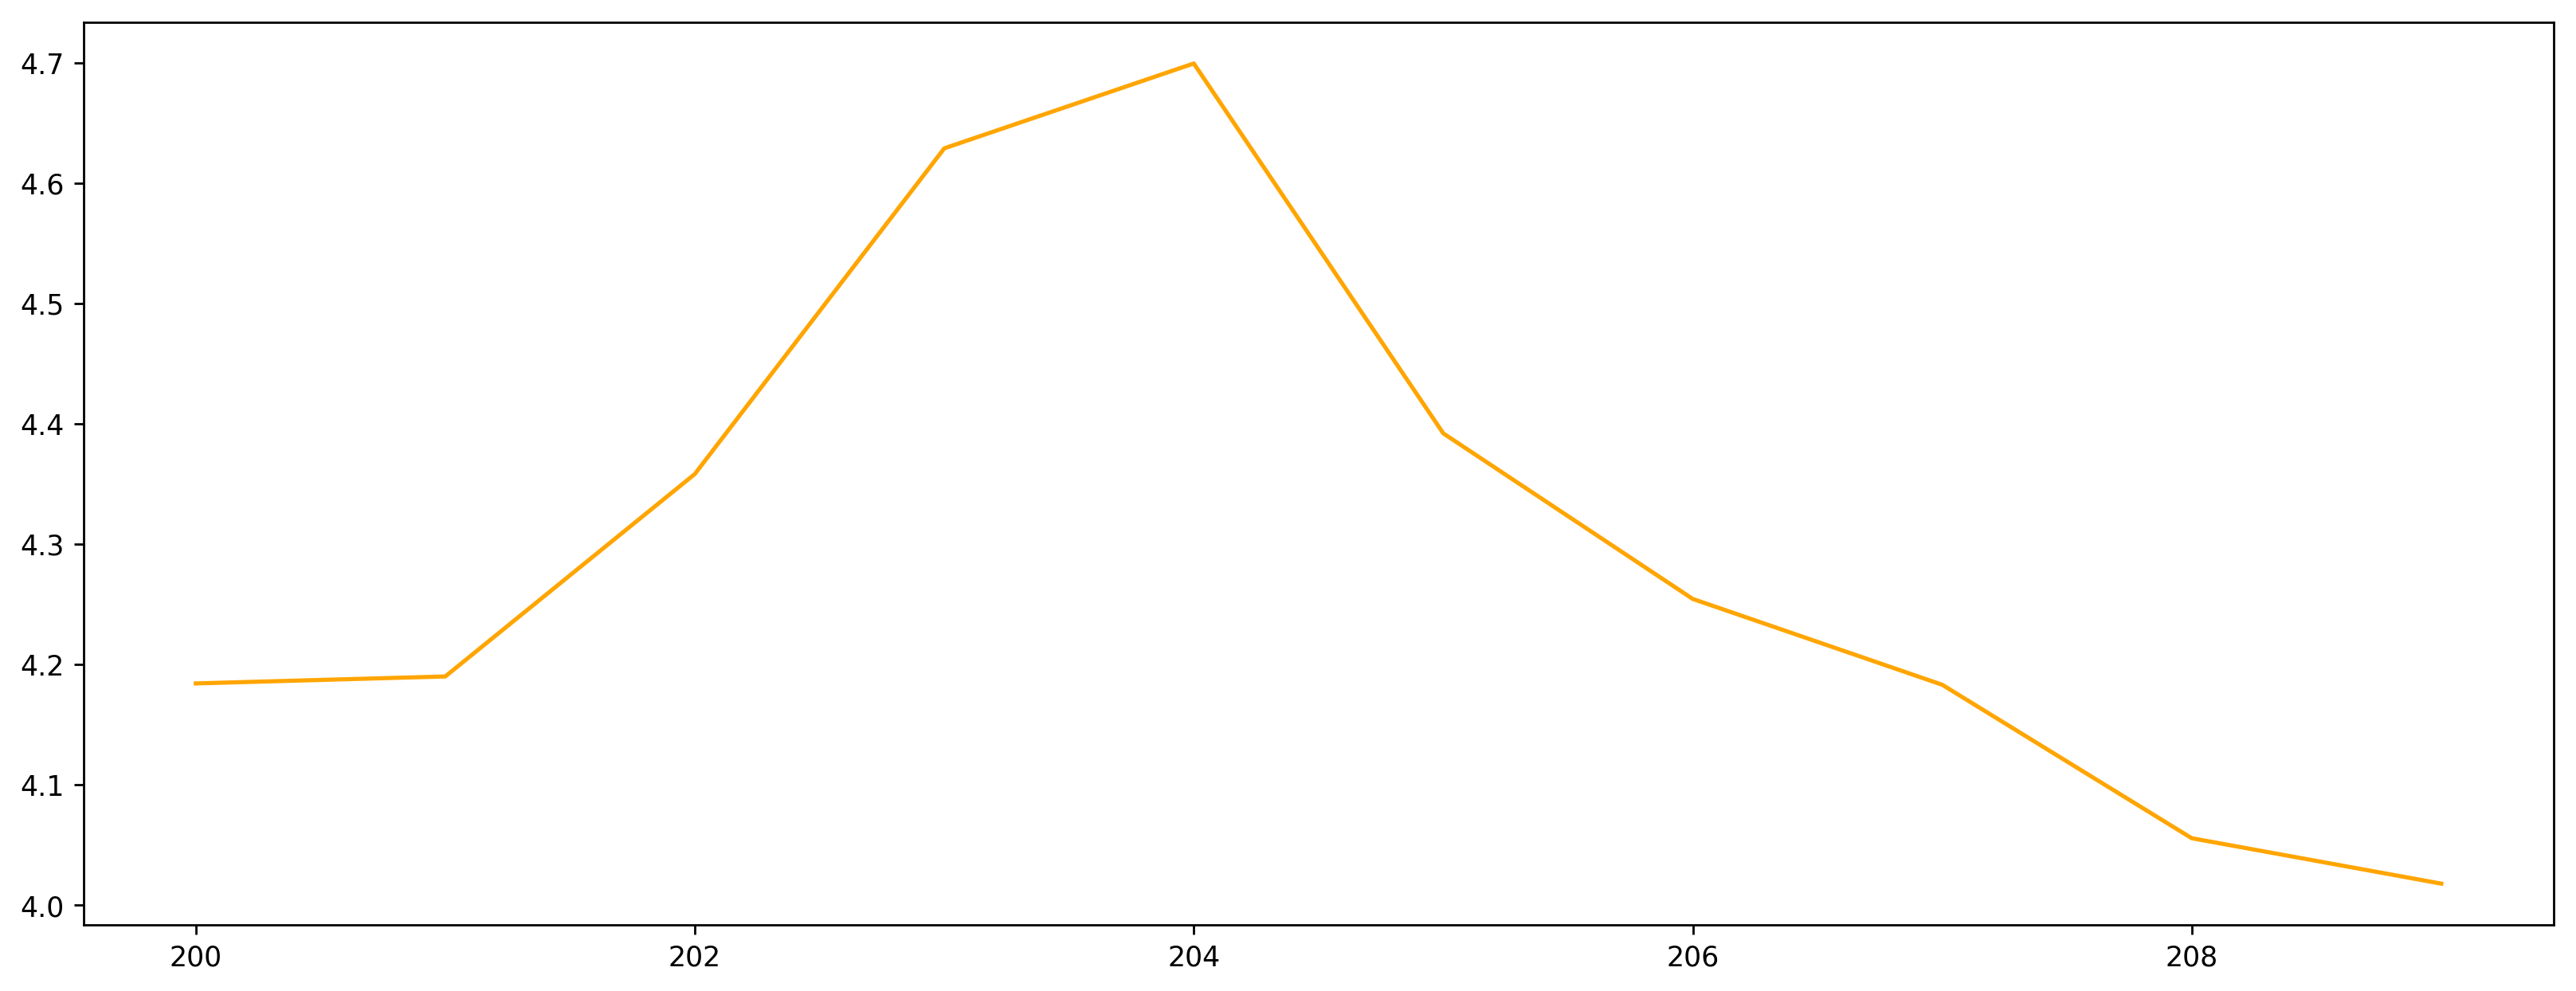

In [151]:
plt.figure(figsize=(16,6),dpi=250)
plt.title="% d'erreur dans la prédiction à 15 minutes"
plt.plot(error,color='orange')


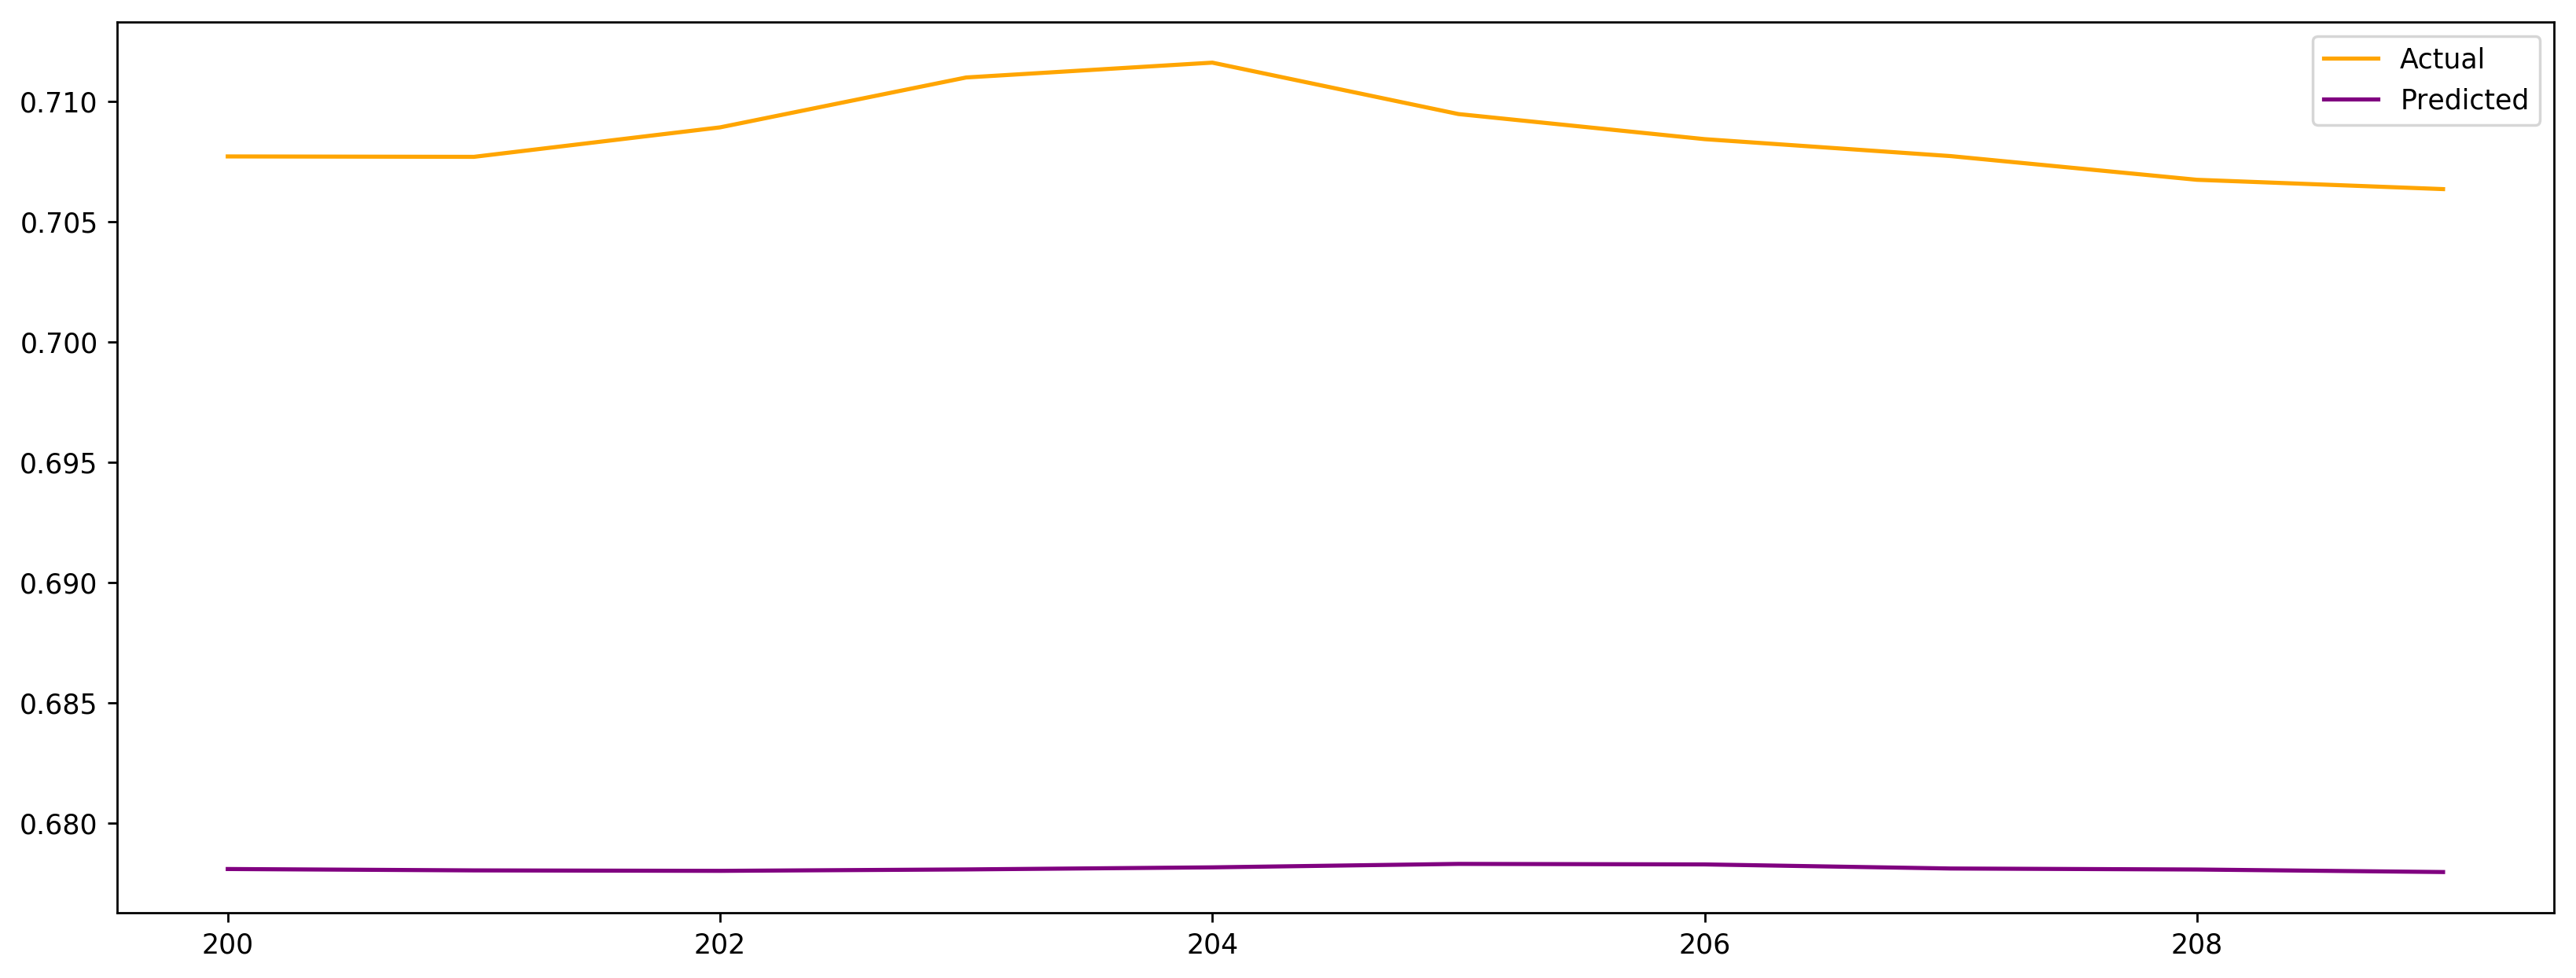

In [140]:
plt.figure(figsize=(16,6),dpi=250)
plt.plot(result.iloc[:,1],label='Actual',color='orange')
plt.plot(result.iloc[:,0],label='Predicted',color='purple')
plt.legend()

In [135]:
data_history = []